In [1]:
from modelling_qard import prep_train_and_test, assess_model
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import naive_bayes
from sklearn import svm
from sklearn import neighbors
from sklearn import model_selection
import docx
from sklearn.externals import joblib
from collections import Counter
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
features_all = pd.read_csv('/project/1_feature_extraction/output_feature_extraction/final/features_all.csv', index_col=0)
features_all.head()

,LTdebt-to-equity,balance_sheet_type,current_ratio,debt-to-assets,debt-to-equity,debt-to-income,financial_leverage,profitability,quick_ratio,label,...,trust_ts_flag,trust_flag,nb_domains,tech_cms,tech_widgets,tech_analytics,tech_enhanced_advertisment,tech_interactiveness,tech_enhanced_security,tech_ecommerce
530772565,-0.487377,C,0.801049,1.152215,-7.569634,-7.883752,-6.569634,-0.032368,0.451459,1,...,1,1,2,1,1,1,1,1,0,PrestaShop
388336000,0.023354,C,5.353047,0.196319,0.244274,2.250454,1.244274,0.041878,3.351257,0,...,0,0,3,1,0,1,0,0,0,Magento
519216188,0.770238,C,3.863614,0.569031,1.320353,1.501278,2.320353,0.079612,1.867462,0,...,0,1,1,0,0,0,1,0,1,PrestaShop
382528958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,1,0,0,1,1,0,0,PrestaShop
495049132,0.259507,C,3.157351,0.433500,0.765336,7.902094,1.765483,0.010329,0.681631,0,...,0,0,1,0,1,1,1,0,0,Other


In [3]:
X_train, y_train, X_test, y_test, feature_names = prep_train_and_test(features_all,
                                                                      test_size=0.5,
                                                                      scaling='norm', #'std', 'minmax', 'norm', 'none'
                                                                      resampling='smote-tomek') # 'smote', 'tomek', 'smote-tomek', 'none'
 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('-----------------')
print(feature_names)

(832, 11) (832,) (434, 11) (434,)
-----------------
['drop' 'x0_C' 'x0_S' 'LTdebt-to-equity' 'current_ratio' 'debt-to-assets'
 'debt-to-equity' 'debt-to-income' 'financial_leverage' 'profitability'
 'quick_ratio']


In [4]:
print(y_test.sum())
print(y_test.shape)

10
(434,)


# Random Forest

In [5]:
# Pick classifier
clf = ensemble.RandomForestClassifier(n_estimators=100, bootstrap=True, class_weight={0:1,1:4})

# Train with grid search
params = {'max_depth': range(4,6),
          'min_samples_split': range(2,6),
          'min_impurity_decrease': [0.002, 0.001],
          'max_features': range(2,6)}
grid_search = model_selection.GridSearchCV(clf, params, cv=5)
grid_search.fit(X_train,y_train)
best_clf = grid_search.best_estimator_

Precision on train: 0.8509615384615384
Recall on train: 1.0
Corresponding confusion matrix:
[[354  62]
 [  0 416]]
Precision on test: 0.8372641509433962
Recall on test: 0.5
Corresponding confusion matrix:
[[355  69]
 [  5   5]]
Model: RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 4},
            criterion='gini', max_depth=5, max_features=5,
            max_leaf_nodes=None, min_impurity_decrease=0.002,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Predictors: ['drop' 'x0_C' 'x0_S' 'LTdebt-to-equity' 'current_ratio' 'debt-to-assets'
 'debt-to-equity' 'debt-to-income' 'financial_leverage' 'profitability'
 'quick_ratio']
Threshold: 0.5


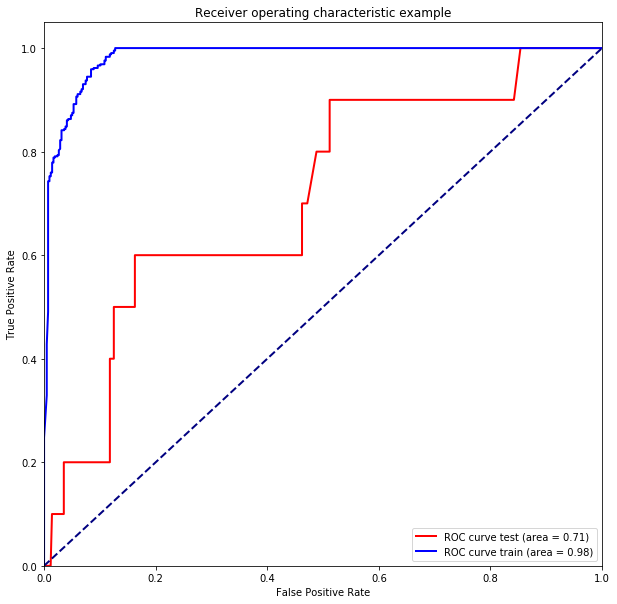

In [6]:
assess_model(X_train, y_train, X_test, y_test, feature_names, best_clf, threshold=0.5)

In [7]:
# save the model to disk
filename = 'financial-good-4-features.sav'
joblib.dump(best_clf, filename)

['financial-good-4-features.sav']

In [8]:
coeff_import = pd.DataFrame({"feature": feature_names,"coefficient": best_clf.feature_importances_})
coeff_import.sort_values(by='coefficient', ascending=False).head()

,feature,coefficient
9,profitability,0.366433
7,debt-to-income,0.203240
10,quick_ratio,0.199357
4,current_ratio,0.092420
3,LTdebt-to-equity,0.044529


In [10]:
perm = PermutationImportance(best_clf, random_state=42).fit(X_train, y_train.ravel())
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
0.2274 ± 0.0373,profitability
0.0921 ± 0.0097,debt-to-income
0.0889 ± 0.0161,quick_ratio
0.0070 ± 0.0010,x0_S
0.0063 ± 0.0028,x0_C
0.0010 ± 0.0018,LTdebt-to-equity
0.0007 ± 0.0012,financial_leverage
0 ± 0.0000,drop
-0.0002 ± 0.0047,current_ratio
-0.0002 ± 0.0010,debt-to-equity


# SVM

In [31]:
# Pick classifier
clf = svm.SVC(gamma='scale', degree=3, probability=True)

# Train with grid search
params = {'C': np.linspace(4, 10, 100),
          'kernel': ['poly']} # PICK PARAMS: 'poly', 'rbf'
grid_search = model_selection.GridSearchCV(clf, params, cv=3)
grid_search.fit(X_train,y_train)
best_clf = grid_search.best_estimator_

Precision on train: 0.6971153846153846
Recall on train: 0.9879807692307693
Corresponding confusion matrix:
[[290 126]
 [  5 411]]
Precision on test: 0.6745283018867925
Recall on test: 0.9
Corresponding confusion matrix:
[[286 138]
 [  1   9]]
Model: SVC(C=7.333333333333334, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predictors: ['drop' 'x0_C' 'x0_S' 'LTdebt-to-equity' 'current_ratio' 'debt-to-assets'
 'debt-to-equity' 'debt-to-income' 'financial_leverage' 'profitability'
 'quick_ratio']
Threshold: 0.083


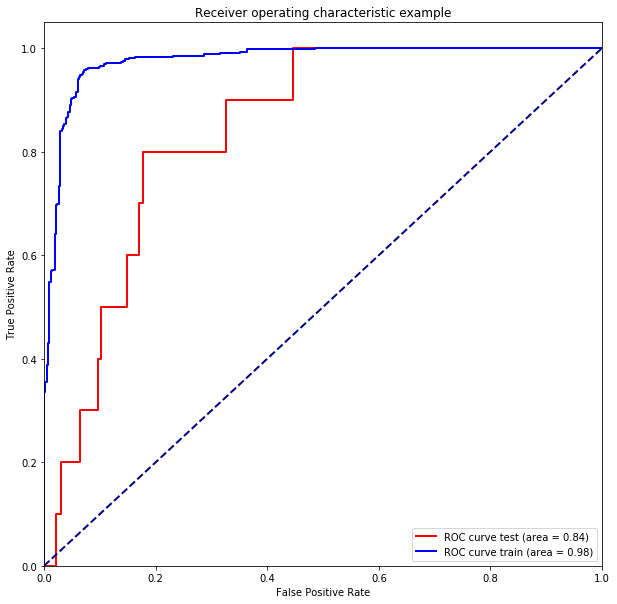

In [50]:
assess_model(X_train, y_train, X_test, y_test, feature_names, best_clf, threshold=0.083)

In [51]:
# save the model to disk
filename = 'svm3.sav'
joblib.dump(best_clf, filename)

['svm3.sav']

In [52]:
perm = PermutationImportance(best_clf, random_state=42).fit(X_train, y_train.ravel())
eli5.show_weights(perm, feature_names = feature_names)

Weight,Feature
0.4026 ± 0.0334,debt-to-income
0.2149 ± 0.0208,current_ratio
0.2014 ± 0.0357,debt-to-equity
0.1411 ± 0.0215,quick_ratio
0.0882 ± 0.0081,financial_leverage
0.0507 ± 0.0056,LTdebt-to-equity
0.0406 ± 0.0093,x0_S
0.0137 ± 0.0025,debt-to-assets
0.0115 ± 0.0025,x0_C
0.0067 ± 0.0033,profitability
